In [2]:
import random
import time
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tempfile
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle

from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential, save_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [3]:
!pip install PyDrive #This Module are used to download file from google drive

In [4]:
auth.authenticate_user() #authenticate your google account 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1NqmSuCu885NcCCfkB3aSsXcMczKhb0I8"})  #get file from google drive
downloaded.GetContentFile('imgs.zip') 

In [7]:
!unzip -q '/content/imgs.zip'

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)
   
    
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True)


val_generator = train_datagen.flow_from_directory(
   '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    subset='validation',
    shuffle=True)


test_generator = test_datagen.flow_from_directory(
   '/content/imgs/test', #change it into your test directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode=None,
    shuffle=False)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 35910 images belonging to 1 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #Print the batch size and labels.

((32, 224, 224, 3), (32, 10))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Doing Hair or Makeup': 0, 'Drinking': 1, 'Operating Radio': 2, 'Reaching Behind': 3, 'Save Driving': 4, 'Talking On The Phone left': 5, 'Talking On The phone Right': 6, 'Talking to passenger': 7, 'Texting Left': 8, 'Texting Right': 9}


In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

checkpointer = tf.keras.callbacks.ModelCheckpoint('cnn_stratch_best.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 512)     14336     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 512)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 256)     1179904   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       295040    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)       

In [ ]:
history = model1.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/10
1122/1122 [==============================] - ETA: 0s - loss: 0.5788 - accuracy: 0.8061
Epoch 00001: val_loss improved from inf to 0.10885, saving model to cnn_stratch_best.hdf5
1122/1122 [==============================] - 648s 578ms/step - loss: 0.5788 - accuracy: 0.8061 - val_loss: 0.1089 - val_accuracy: 0.9708
Epoch 2/10
1122/1122 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9805
Epoch 00002: val_loss improved from 0.10885 to 0.10088, saving model to cnn_stratch_best.hdf5
1122/1122 [==============================] - 648s 578ms/step - loss: 0.0687 - accuracy: 0.9805 - val_loss: 0.1009 - val_accuracy: 0.9732
Epoch 3/10
1122/1122 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9909
Epoch 00003: val_loss improved from 0.10088 to 0.06112, saving model to cnn_stratch_best.hdf5
1122/1122 [==============================] - 647s 577ms/step - loss: 0.0329 - accuracy: 0.9909 - val_loss: 0.0611 - val_accuracy: 0.9850
Epoch 4/10
1122/1

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
plot_train_history(history)


In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

mobnet = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                        include_top=False, 
                                         weights='imagenet')
mobnet.trainable=False

In [ ]:
model2 = tf.keras.Sequential([
  mobnet,
  tf.keras.layers.Conv2D(1024, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('mobnet_wo_ft.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 1024)        9438208   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 1024)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 12,677,322
Trainable params: 9,448,458
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
history1 = model2.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=20, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 2.1284 - accuracy: 0.2590
Epoch 00001: val_loss improved from inf to 1.70397, saving model to mobnet_wo_ft.hdf5
18/18 [==============================] - 114s 6s/step - loss: 2.1284 - accuracy: 0.2590 - val_loss: 1.7040 - val_accuracy: 0.5334
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 1.4415 - accuracy: 0.6459
Epoch 00002: val_loss improved from 1.70397 to 1.16224, saving model to mobnet_wo_ft.hdf5
18/18 [==============================] - 111s 6s/step - loss: 1.4415 - accuracy: 0.6459 - val_loss: 1.1622 - val_accuracy: 0.7797
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.8163
Epoch 00003: val_loss improved from 1.16224 to 0.80263, saving model to mobnet_wo_ft.hdf5
18/18 [==============================] - 112s 6s/step - loss: 0.9861 - accuracy: 0.8163 - val_loss: 0.8026 - val_accuracy: 0.8748
Epoch 4/20
18/18 [==============================] - ETA: 0s - 

In [ ]:
def plot_train_history(history1):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

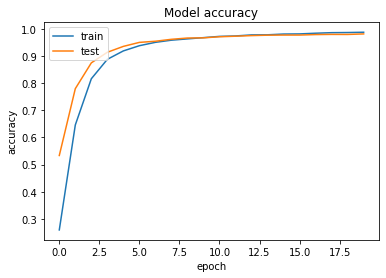

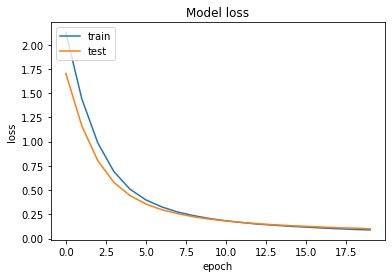

In [ ]:
plot_train_history(history)


In [ ]:
model=tf.keras.models.load_model("./mobnet_wo_ft.hdf5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)  